<h1 style="font-family:Impact,Arial;font-size:30px;">37005 Fundamental of Derivative Security Pricing - Spring 2024</h1>
<h1 style="font-family:Impact,Arial;font-size:20px;">Group Assignment Part 1</h1>
<p style="font-family:Arial;">Group 1</p>
<ul>
<li>Hayoung Lee</li>
<li>Quoc Thai Tran</li>
<li>Alexis Cullet</li>
<li>Ziqi Zhou</li>
</ul>


# Import package


In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, fsolve, NonlinearConstraint
from scipy.stats import norm
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numba import jit

INDEX_LEVEL = 4170.7002
TODAY = pd.to_datetime('2022-03-08')
MATURITY = pd.to_datetime('2026-12-18')

# Import data


In [2]:
def data_preprocessing():
    df = pd.read_excel('spx_quotedata20220308_all.xlsx')
    df.drop(columns=['Last Sale', 'Calls', 'Net', 'IV', 'Delta', 'Gamma', 'Open Interest', 'Puts', 'Last Sale.1', 'Net.1', 'IV.1', 'Delta.1', 'Gamma.1', 'Open Interest.1'], inplace=True)
    df.rename(columns={'Bid': 'Call Bid', 'Ask': 'Call Ask', 'Volume': 'Call Volume', 'Bid.1':'Put Bid', 'Ask.1':'Put Ask', 'Volume.1':'Put Volume'}, inplace=True)
    df['Expiration Date']=pd.to_datetime(df['Expiration Date'], format='%a %b %d %Y')
    df['Call Price']=(df['Call Bid']+df['Call Ask'])/2
    df['Put Price']=(df['Put Bid']+df['Put Ask'])/2
    df.sort_values(by=['Expiration Date', 'Strike'], ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    columns = df.columns.tolist()
    return df[columns[:2]+['Call Price']+columns[2:6]+['Put Price']+columns[6:-2]]
data_processed = data_preprocessing()
data_processed

,Expiration Date,Call Bid,Call Price,Call Ask,Call Volume,Strike,Put Bid,Put Price,Put Ask,Put Volume
0,2022-03-09,1151.7,1160.30,1168.9,0,3000,0.0,0.025,0.05,6
1,2022-03-09,951.7,960.40,969.1,0,3200,0.0,0.025,0.05,4
2,2022-03-09,851.2,860.25,869.3,0,3300,0.0,0.025,0.05,2182
3,2022-03-09,751.7,760.40,769.1,0,3400,0.0,0.025,0.05,360
4,2022-03-09,651.2,660.30,669.4,0,3500,0.0,0.025,0.05,1264
...,...,...,...,...,...,...,...,...,...,...
5886,2026-12-18,34.3,74.30,114.3,0,7200,2602.4,2698.400,2794.40,80
5887,2026-12-18,0.0,150.00,300.0,0,8000,3299.5,3395.500,3491.50,3
5888,2026-12-18,0.0,150.00,300.0,0,8600,3832.4,3928.400,4024.40,5
5889,2026-12-18,0.0,150.00,300.0,0,9000,4190.1,4286.100,4382.10,2


# Task 1

Task 1 result
     Maturity  Dividend Discount Factor  Zero Coupon Bond
0  2022-03-09                  0.997496          0.999965
1  2022-03-11                  0.997462          1.000079
2  2022-03-14                  0.997263          1.000150
3  2022-03-16                  0.997030          0.999847
4  2022-03-18                  0.996945          0.999927
5  2022-03-21                  0.997252          1.000222
6  2022-03-23                  0.997327          1.000346
7  2022-03-25                  0.996831          0.999867
8  2022-03-28                  0.996913          0.999969
9  2022-03-30                  0.996952          1.000063
10 2022-03-31                  0.996890          1.000010
11 2022-04-01                  0.996910          1.000076
12 2022-04-04                  0.996823          0.999953
13 2022-04-06                  0.997161          1.000491
14 2022-04-08                  0.996610          1.000066
15 2022-04-14                  0.996567          1.000017


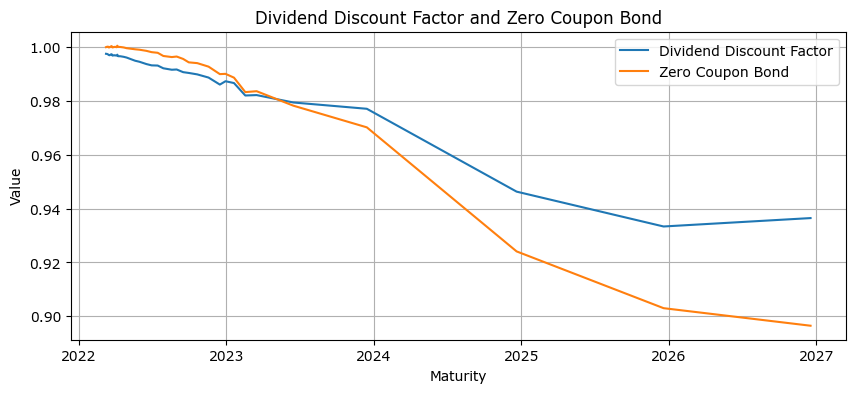

In [3]:
def task_1(stock):
    df = data_processed.copy()
    maturity = list(set(df['Expiration Date']))
    dividend = []
    discount_factor = []
    for date in maturity:
        data = df[df['Expiration Date']==date]
        strike = data['Strike'].to_numpy()
        call = data['Call Price'].to_numpy()
        put = data['Put Price'].to_numpy()
        def target_minimizer(x):
            calc = x[0]*stock-x[1]*strike-(call-put)
            return np.sum(np.power(calc-np.mean(calc),2))
        result = minimize(target_minimizer, np.ones(2), constraints={
            'type':'eq',
            'fun':lambda x: np.sum(x[0]*stock-x[1]*strike-(call-put))
        }).x
        dividend.append(result[0])
        discount_factor.append(result[1])
    information = pd.DataFrame({'Maturity':pd.to_datetime(maturity), 'Dividend Discount Factor':dividend, 'Zero Coupon Bond':discount_factor})
    information.sort_values(by=['Maturity'], ascending=True, inplace=True)
    information.reset_index(drop=True, inplace=True)
    return information
task_1_df = task_1(INDEX_LEVEL)
print("Task 1 result")
print(task_1_df)
plt.figure(figsize=(10,4))
plt.plot(task_1_df['Maturity'], task_1_df['Dividend Discount Factor'], label='Dividend Discount Factor')
plt.plot(task_1_df['Maturity'], task_1_df['Zero Coupon Bond'], label='Zero Coupon Bond')
plt.xlabel('Maturity')
plt.ylabel('Value')
plt.grid()
plt.title('Dividend Discount Factor and Zero Coupon Bond')
plt.legend()
plt.show()

# Task 2

$dS(T) = S(t) (\mu dt+\sigma dW(t)) $

$=S(t) ((r(t) - q(t))dt + \sigma (t) dW(t)) $

Applying Itô's lemma :

$\ln(S(T)) = \ln(S(0)) + \int_{0}^{T} r(t)dt - \int_{0}^{T} q(t)dt -\frac{1}{2} \int_{0}^{T} \sigma^{2}(t)dt + \int_{0}^{T} \sigma(t) dW(t) $

Therefore

$\ln(S(T)) = \ln(S(0)) - \ln (B(0,T)) + \ln(D(0,T)) -\frac{1}{2} \sum_{i=1}^{N} \int_{T_{i-1}}^{T_i} \sigma_i^2 dt + \sum_{i=1}^{N} \int_{T_{i-1}}^{T_i} \sigma_i dW(t) $

So we have

$\ln(S(0)\frac{D(0,T)}{B(0,T)}) -\frac{1}{2} \sum_{i=1}^{N} \sigma_i^2(T_i - T_{i-1}) + \sum_{i=1}^{N} \sigma_i(W(T_i) - W(T_{i-1}))  $



$\implies \ln(S(T)) \sim \mathcal{N} (\ln(S(0)\frac{D(0,T)}{B(0,T)})-\frac{1}{2} \sum_{i=1}^{N} \sigma_i^2(T_i - T_{i-1})  ,  \sum_{i=1}^{N} \sigma_i^2(T_i - T_{i-1})) $

Which yields the following classical Black-Scholes formula :

$$
C(0)=S(0)D(0,T_i)\phi(d_1)-KB(0,T_i)\phi(d_2)
$$

with


$$
d_{1,2}=\frac{\ln(\frac{S(0)}{K})-\ln(\frac{B(0,T_i)}{D(0,T_i)})\pm\frac{1}{2}\sum_{i=1}^{n}\sigma _i^2(T_i-T_{i-1})}{\sqrt{\sum_{i=1}^{n}\sigma _i^2(T_i-T_{i-1})}}
$$

Task 2 result
     Maturity  Bid Implied Volatility  Ask Implied Volatility
0  2022-03-09                0.341898                0.413275
1  2022-03-11                0.336409                0.351895
2  2022-03-14                0.275448                0.236758
3  2022-03-16                0.398176                0.400603
4  2022-03-18                0.287762                0.382516
5  2022-03-21                0.277681                0.192261
6  2022-03-23                0.331576                0.331044
7  2022-03-25                0.322377                0.326044
8  2022-03-28                0.196921                0.200403
9  2022-03-30                0.315007                0.316442
10 2022-03-31                0.346907                0.348431
11 2022-04-01                0.350036                0.346541
12 2022-04-04                0.187724                0.191559
13 2022-04-06                0.307043                0.311270
14 2022-04-08                0.325269                0.3

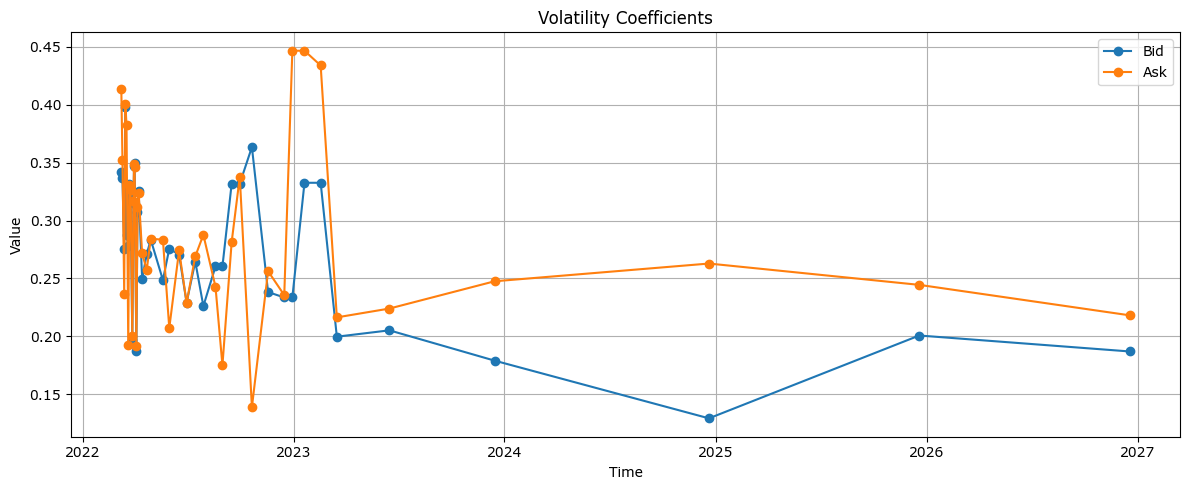

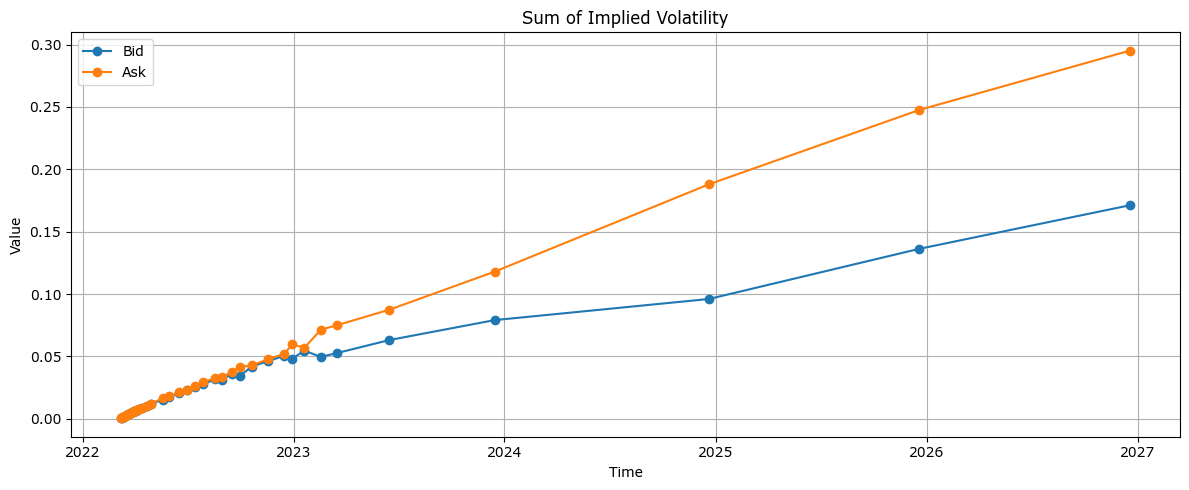

In [4]:
def task_2(stock, noti=None):
    data = data_processed.copy()
    dfs = task_1_df.copy()
    today = TODAY
    vola = [[],[]]
    sigma = [[],[]]
    for i in range(len(dfs)):
        ext_data = data[data['Expiration Date']==dfs.iloc[i,0]].reset_index(drop=True)
        ext_data['diff']=np.abs(ext_data['Strike']-stock*dfs.iloc[i,1]/dfs.iloc[i,2])
        chosen_data = list(ext_data.loc[ext_data['diff'].idxmin()])[:-1]
        isCall = True if chosen_data[3]-chosen_data[1]>chosen_data[8]-chosen_data[6] else False
        def solver(x, type):
            d1 = (np.log(stock/chosen_data[5])-np.log(dfs.iloc[i,2]/dfs.iloc[i,1])+0.5 * x)/(np.sqrt(x))
            d2 = d1-np.sqrt(x)
            if isCall:
                return stock*dfs.iloc[i,1]*norm.cdf(d1)-chosen_data[5]*dfs.iloc[i,2]*norm.cdf(d2) - chosen_data[1 if type=='bid' else 3]
            else:
                return chosen_data[5]*dfs.iloc[i,2]*norm.cdf(-d2)-stock*dfs.iloc[i,1]*norm.cdf(-d1) - chosen_data[6 if type=='bid' else 8]
        vola[0].append(fsolve(solver, 0.001, args=('bid'))[0])
        vola[1].append(fsolve(solver, 0.001, args=('ask'))[0])
    sum_vola=pd.DataFrame({'Maturity':dfs['Maturity'], 'Bid Implied Volatility':vola[0], 'Ask Implied Volatility':vola[1]})
    vola[0]=np.concatenate(([vola[0][0]],np.diff(vola[0])))
    vola[1]=np.concatenate(([vola[1][0]],np.diff(vola[1])))
    for i in range(len(dfs)):
        delta_t = (dfs.iloc[i,0]-today).days/((today+pd.DateOffset(years=1))-today).days if i==0 else (dfs.iloc[i,0]-dfs.iloc[i-1,0]).days/((dfs.iloc[i-1,0]+pd.DateOffset(years=1))-dfs.iloc[i-1,0]).days
        for j in range(2):
            if vola[j][i]<0:
                if noti is not None:
                    print('Negative Volatility Detected: Maturity:', dfs.iloc[i,0], 'Type:', 'Bid' if j==0 else 'Ask','. Set to previous value: ', sigma[j][-1])
                sigma[j].append(sigma[j][-1])
            else:
                sigma[j].append(np.sqrt(vola[j][i]/delta_t))
    return pd.DataFrame({'Maturity':dfs['Maturity'], 'Bid Implied Volatility':sigma[0], 'Ask Implied Volatility':sigma[1]}), sum_vola
task_2_df, sum_volatility = task_2(INDEX_LEVEL)
print("Task 2 result")
print(task_2_df)
print("Implied Volatility")
print(sum_volatility)
plt.figure(figsize=(12, 5))
plt.plot(task_2_df['Maturity'], task_2_df['Bid Implied Volatility'], label='Bid', marker='o')
plt.plot(task_2_df['Maturity'], task_2_df['Ask Implied Volatility'], label='Ask', marker='o')
plt.title('Volatility Coefficients')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 5))
plt.plot(sum_volatility['Maturity'], sum_volatility['Bid Implied Volatility'], label='Bid', marker='o')
plt.plot(sum_volatility['Maturity'], sum_volatility['Ask Implied Volatility'], label='Ask', marker='o')
plt.title('Sum of Implied Volatility')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Task 4

before # "Fair" guarantee level g --> Value of the contract calculated by volatility with bid price = Value of the contract calculated by volatility with ask price  

now # "Fair" guarantee level g --> S(0) = value of the contract using implied ask volatility

It means that the option's price matches the client's investment

ith sum_vol : $\sigma_i^2 (T_i - T_{i-1})$

sum of implied ask volatility : $\sum_{i=1}^{n}\sigma_i^2 (T_i - T_{i-1})$

In [5]:
def year_transform(today, date):
    runner = today
    days = (date-runner).days
    year = 0
    while days>0:
        next_runner = runner + pd.DateOffset(years=1)
        if days>(next_runner-runner).days:
            year += 1
            days -= (next_runner-runner).days
        else:
            year += days/(next_runner-runner).days
            days -= days
        runner = next_runner
    return year

In [6]:
def guarantee(stock, alpha, initial_value, sum_vola):
    dfs = task_1_df.copy()
    today = TODAY
    maturity = MATURITY
    D_0T = dfs[dfs['Maturity']==maturity].iloc[0,1] 
    B_0T = dfs[dfs['Maturity']==maturity].iloc[0,2]
    TimeToMat = year_transform(today, maturity)
    def solver(g):
        h1_ask = (g * TimeToMat / (1-alpha) - np.log(D_0T/B_0T) + 1/2 * sum_vola ) / np.sqrt(sum_vola)
        h2_ask = ( - g * TimeToMat / (1-alpha) + np.log(D_0T/B_0T) + (1/2-alpha) * sum_vola ) / np.sqrt(sum_vola)
        Val_ask = B_0T * (stock * np.exp(g * TimeToMat) * norm.cdf(h1_ask) + stock * ((D_0T/B_0T)** (1-alpha)) * np.exp( (alpha**2 - alpha)/2 *sum_vola) * norm.cdf(h2_ask))
        return stock - Val_ask
    return fsolve(solver, initial_value)[0]
_, sum_vola = task_2(INDEX_LEVEL)

guarantees = [(alpha, guarantee(INDEX_LEVEL, alpha, 0.05, sum_vola[sum_vola['Maturity']==MATURITY].iloc[0,2])) for alpha in [0.25, 0.5, 0.75]]

for couple in guarantees:
    print("alpha:",couple[0],"guarantee g:", couple[1])

alpha: 0.25 guarantee g: -0.02027644662804652
alpha: 0.5 guarantee g: 0.00540243001096912
alpha: 0.75 guarantee g: 0.019758362741833485


# Task 5

 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 4449.805529863282
       x: [ 5.832e-05  3.823e-05 ...  4.249e-01  9.944e+02]
     nit: 198
     jac: [-1.841e+03 -1.287e+03 ...  4.562e+03  8.965e-01]
    nfev: 10521
    njev: 194
4449.805529863282
34.49845288821962
[5.83215623e-05 3.82311969e-05 8.57445066e-05 7.08685844e-05
 6.25154317e-05 1.72851880e-04 5.09415879e-02 1.21965980e-02
 2.06610086e-02 2.50048689e-05 7.18556026e-05 4.47232400e-01
 4.04221391e-01 1.02615964e-01 6.15610206e-01 1.05377422e-04
 1.08631725e-04 9.40082185e-05 6.05209801e-03 5.43569059e-03
 1.27088086e-05 9.51445836e-06 2.56588094e-06 7.09335860e-07
 3.98666201e-01 5.75440955e-05 2.57425702e-05 1.49257382e-04
 5.08133525e-06 2.70325698e-02 6.50088986e-04 4.62389510e-05
 4.00166355e-05 4.08181949e-05 3.63874642e-05 9.22092795e-05
 2.03432201e-07 8.73773702e-06 9.14566016e-06 1.02252832e-05
 8.40661426e-05 8.16478038e-05 7.33886598e-05 7.52319403e-05
 1.22660410e-04 

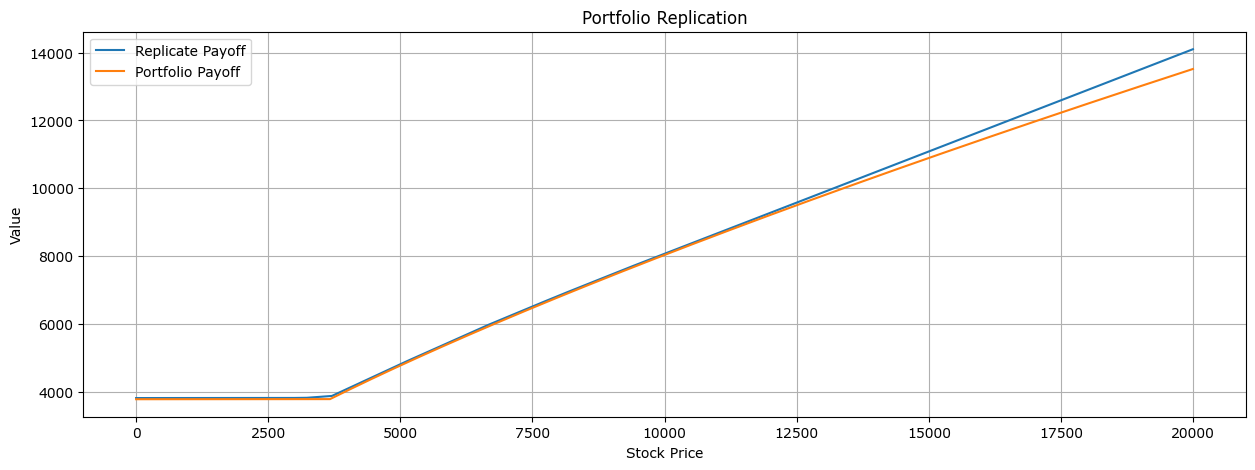

In [7]:
def task_5(guarantee):
    alpha = guarantee[0]
    g = guarantee[1]
    filter_data = data_processed[data_processed['Expiration Date']==MATURITY].reset_index(drop=True)
    filter_data.sort_values(by=['Strike'], ascending=True, inplace=True)
    filter_data.reset_index(drop=True, inplace=True)
    price = np.concatenate((filter_data['Call Bid'].to_numpy(), filter_data['Call Ask'].to_numpy(), filter_data['Put Bid'].to_numpy(), filter_data['Put Ask'].to_numpy()))
    strike = filter_data['Strike'].to_numpy()
    time_to_maturity = year_transform(TODAY, MATURITY)
    B_0T = task_1_df[task_1_df['Maturity']==MATURITY].iloc[0,2]
    @jit(forceobj=True)
    def replicate_payoff(x, position):
        short_call_position = position[:len(strike)]
        long_call_position = position[len(strike):2*len(strike)]
        short_put_position = position[2*len(strike):3*len(strike)]
        long_put_position = position[3*len(strike):4*len(strike)]
        call_position = long_call_position-short_call_position
        put_position = long_put_position-short_put_position
        return np.sum(call_position*np.maximum(x-strike,0))+position[-1]+np.sum(put_position*np.maximum(strike-x,0))
    def portfolio_payoff(x):
        return max(INDEX_LEVEL*np.exp(g*time_to_maturity),(INDEX_LEVEL**alpha)*((x if x>0 else 0) ** (1-alpha)))
    def payoff_diff(x, position):
        position = np.array(position)
        return replicate_payoff(x, position)-portfolio_payoff(x)
    def smallest_diff(position, step=10, alpha=1):
        position = np.array(position)
        values = np.arange(0, 20000, step)
        diffs = list(map(lambda x: payoff_diff(x, position), values))
        return min(diffs)*alpha
    def value(x):
        # x_value = np.concatenate((x[len(strike)*0:len(strike)*1], x[len(strike)*1:len(strike)*2]))
        # test_price = np.concatenate((price[len(strike)*0:len(strike)*1], price[len(strike)*1:len(strike)*2]))
        # x_value = x_value*np.concatenate((-np.ones(len(strike)), np.ones(len(strike))))
        # if smallest_diff(x, 10)<0:
        #     return np.inf
        x_value = np.array(x[:-1])
        x_value = x_value*np.concatenate((-np.ones(len(strike)), np.ones(len(strike)), -np.ones(len(strike)), np.ones(len(strike))))
        return np.sum(x_value*price)+x[-1]*B_0T
    positions = None
    for _ in range(1):
        positions = minimize(value, [0]*len(price)+[1000] if positions is None else positions.x, options={
            'maxiter':1000
        },constraints=NonlinearConstraint(smallest_diff, 40, np.inf), bounds=[(0,1) for _ in range(len(price))]+[(900,1e10)])
        print(positions)
        if positions.success:
            break
    positions = positions.x
    def plot(smaller, bigger, position=positions):
        S = np.arange(smaller, bigger, 1)
        plt.figure(figsize=(15, 5))
        plt.plot(S, list(map(lambda x: replicate_payoff(x, position), S)), label='Replicate Payoff')
        plt.plot(S, list(map(lambda x: portfolio_payoff(x), S)), label='Portfolio Payoff')
        plt.xlabel('Stock Price')
        plt.ylabel('Value')
        plt.title('Portfolio Replication')
        plt.legend()
        plt.grid()
        plt.show()
    return value(positions), positions, plot, lambda x,y: smallest_diff(x,y,1), value
value, position, plot, smallest_diff, cost_cal = task_5(guarantees[0])
print(value)
print(smallest_diff(position,1))
print(position)
plot(0, 20000)

4418.8778799835145


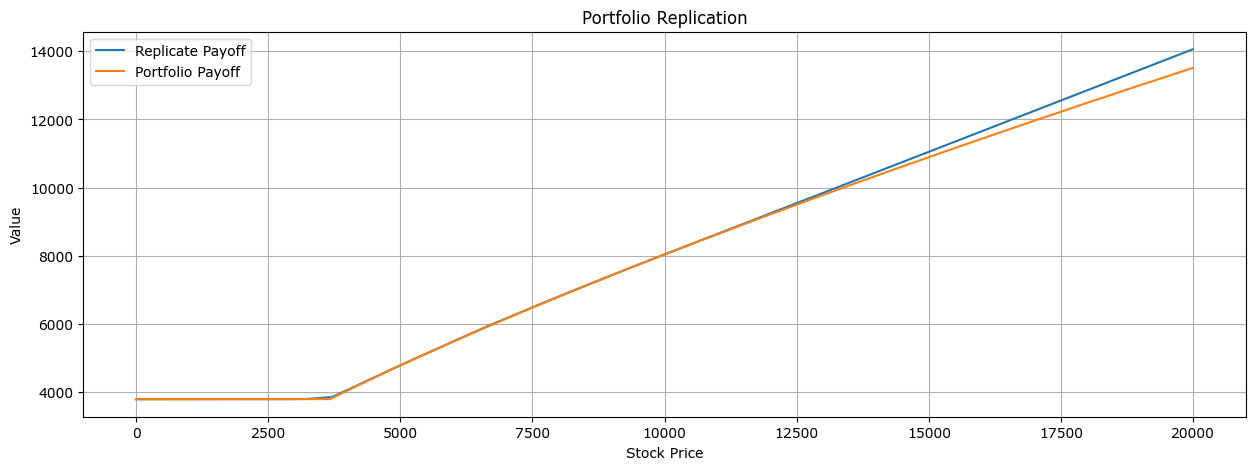

[5.83215623e-05 3.82311969e-05 8.57445066e-05 7.08685844e-05
 6.25154317e-05 1.72851880e-04 5.09415879e-02 1.21965980e-02
 2.06610086e-02 2.50048689e-05 7.18556026e-05 4.47232400e-01
 4.04221391e-01 1.02615964e-01 6.15610206e-01 1.05377422e-04
 1.08631725e-04 9.40082185e-05 6.05209801e-03 5.43569059e-03
 1.27088086e-05 9.51445836e-06 2.56588094e-06 7.09335860e-07
 3.98666201e-01 5.75440955e-05 2.57425702e-05 1.49257382e-04
 5.08133525e-06 2.70325698e-02 6.50088986e-04 4.62389510e-05
 4.00166355e-05 4.08181949e-05 3.63874642e-05 9.22092795e-05
 2.03432201e-07 8.73773702e-06 9.14566016e-06 1.02252832e-05
 8.40661426e-05 8.16478038e-05 7.33886598e-05 7.52319403e-05
 1.22660410e-04 1.24509785e-03 2.85680427e-04 4.24852699e-01
 9.59931675e+02]


In [8]:
test_positions = np.array(position)
test_positions[-1] -= smallest_diff(position,0.1)
print(cost_cal(test_positions))
plot(0, 20000, test_positions)
print(test_positions)

positions = [5.83215623e-05 3.82311969e-05 8.57445066e-05 7.08685844e-05
 6.25154317e-05 1.72851880e-04 5.09415879e-02 1.21965980e-02
 2.06610086e-02 2.50048689e-05 7.18556026e-05 4.47232400e-01
 4.04221391e-01 1.02615964e-01 6.15610206e-01 1.05377422e-04
 1.08631725e-04 9.40082185e-05 6.05209801e-03 5.43569059e-03
 1.27088086e-05 9.51445836e-06 2.56588094e-06 7.09335860e-07
 3.98666201e-01 5.75440955e-05 2.57425702e-05 1.49257382e-04
 5.08133525e-06 2.70325698e-02 6.50088986e-04 4.62389510e-05
 4.00166355e-05 4.08181949e-05 3.63874642e-05 9.22092795e-05
 2.03432201e-07 8.73773702e-06 9.14566016e-06 1.02252832e-05
 8.40661426e-05 8.16478038e-05 7.33886598e-05 7.52319403e-05
 1.22660410e-04 1.24509785e-03 2.85680427e-04 4.24852699e-01
 9.94430128e+02]

 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 4255.435790508937
       x: [ 5.873e-05  4.107e-05 ...  0.000e+00  4.313e+03]
     nit: 29
     jac: [-1.841e+03 -1.287e+03 ...  4.562e+03  8.965e-01]
    nfev: 1275
    njev: 25
Smallest diff -5.82846921226519
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 4255.435790508937
       x: [ 5.873e-05  4.107e-05 ...  0.000e+00  4.313e+03]
     nit: 5
     jac: [-1.841e+03 -1.287e+03 ...  4.562e+03  8.965e-01]
    nfev: 47
    njev: 1
Smallest diff -5.82846921226519
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 4255.435790508937
       x: [ 5.873e-05  4.107e-05 ...  0.000e+00  4.313e+03]
     nit: 5
     jac: [-1.841e+03 -1.287e+03 ...  4.562e+03  8.965e-01]
    nfev: 47
    njev: 1
Smallest diff -5.82846921226519
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     

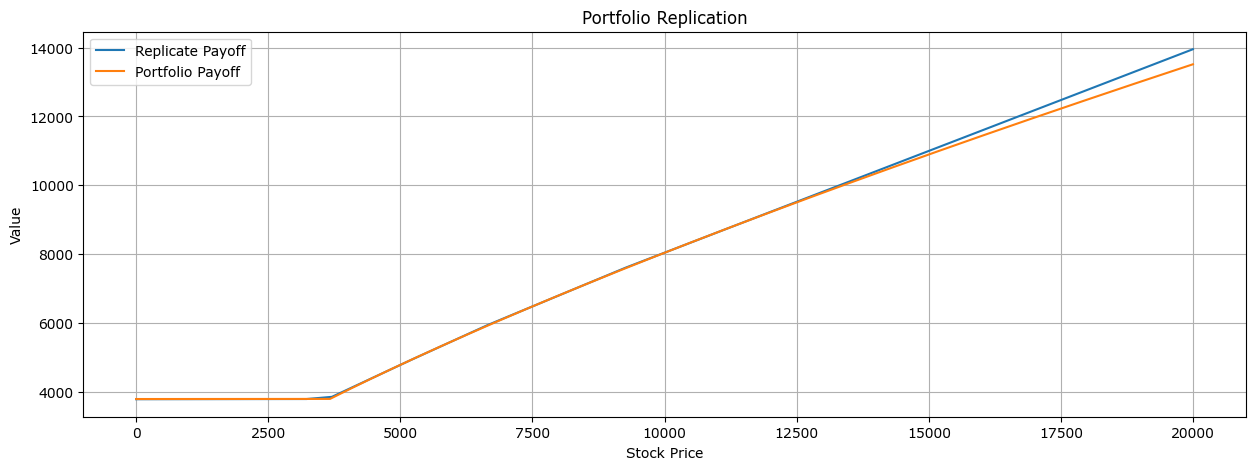

In [27]:
def task_5(guarantee):
    alpha = guarantee[0]
    g = guarantee[1]
    filter_data = data_processed[data_processed['Expiration Date']==MATURITY].reset_index(drop=True)
    filter_data.sort_values(by=['Strike'], ascending=True, inplace=True)
    filter_data.reset_index(drop=True, inplace=True)
    price = np.concatenate((filter_data['Call Bid'].to_numpy(), filter_data['Call Ask'].to_numpy(), filter_data['Put Bid'].to_numpy(), filter_data['Put Ask'].to_numpy()))
    strike = filter_data['Strike'].to_numpy()
    time_to_maturity = year_transform(TODAY, MATURITY)
    B_0T = task_1_df[task_1_df['Maturity']==MATURITY].iloc[0,2]
    @jit(forceobj=True)
    def replicate_payoff(x, position):
        short_call_position = position[:len(strike)]
        long_call_position = position[len(strike):2*len(strike)]
        short_put_position = position[2*len(strike):3*len(strike)]
        long_put_position = position[3*len(strike):4*len(strike)]
        call_position = long_call_position-short_call_position
        put_position = long_put_position-short_put_position
        return np.sum(call_position*np.maximum(x-strike,0))+position[-1]+np.sum(put_position*np.maximum(strike-x,0))
    def portfolio_payoff(x):
        return max(INDEX_LEVEL*np.exp(g*time_to_maturity),(INDEX_LEVEL**alpha)*((x if x>0 else 0) ** (1-alpha)))
    def payoff_diff(x, position):
        position = np.array(position)
        return replicate_payoff(x, position)-portfolio_payoff(x)
    def smallest_diff(position, step=10, alpha=1):
        position = list(position)
        position = position[:8]+[0,0,0]+position[8:]
        position = np.array(position)
        diff = list(map(lambda x: payoff_diff(x, position), np.arange(0, 20000, step)))
        return np.array(diff)
    def value(x):
        x = list(x)
        x = x[:8]+[0,0,0]+x[8:]
        x_value = np.array(x[:-1])
        x_value = x_value*np.concatenate((-np.ones(len(strike)), np.ones(len(strike)), -np.ones(len(strike)), np.ones(len(strike))))
        return np.sum(x_value*price)+x[-1]*B_0T
    positions = None
    for _ in range(20):
        positions = minimize(value, [1]*(45)+[1000] if positions is None else positions.x, options={
            'maxiter':1000
        }, constraints={'type':'ineq', 'fun': smallest_diff}, bounds=[(0,np.inf) for _ in range(len(price)-3)]+[(-np.inf,np.inf)])
        print(positions)
        print('Smallest diff', min(smallest_diff(positions.x,1)))
        if positions.success:
            break
    positions = positions.x
    def plot(smaller, bigger, position=positions):
        position = list(position)
        position = np.array(position[:8]+[0,0,0]+position[8:])
        S = np.arange(smaller, bigger, 1)
        plt.figure(figsize=(15, 5))
        plt.plot(S, list(map(lambda x: replicate_payoff(x, position), S)), label='Replicate Payoff')
        plt.plot(S, list(map(lambda x: portfolio_payoff(x), S)), label='Portfolio Payoff')
        plt.xlabel('Stock Price')
        plt.ylabel('Value')
        plt.title('Portfolio Replication')
        plt.legend()
        plt.grid()
        plt.show()
    return value(positions), positions, plot, lambda x,y: smallest_diff(x,y,1), value
value, position, plot, smallest_diff, cost_cal = task_5(guarantees[0])
print(value)
print(min(smallest_diff(position,1)))
print(position)
plot(0, 20000)

4260.660977161976
0.0


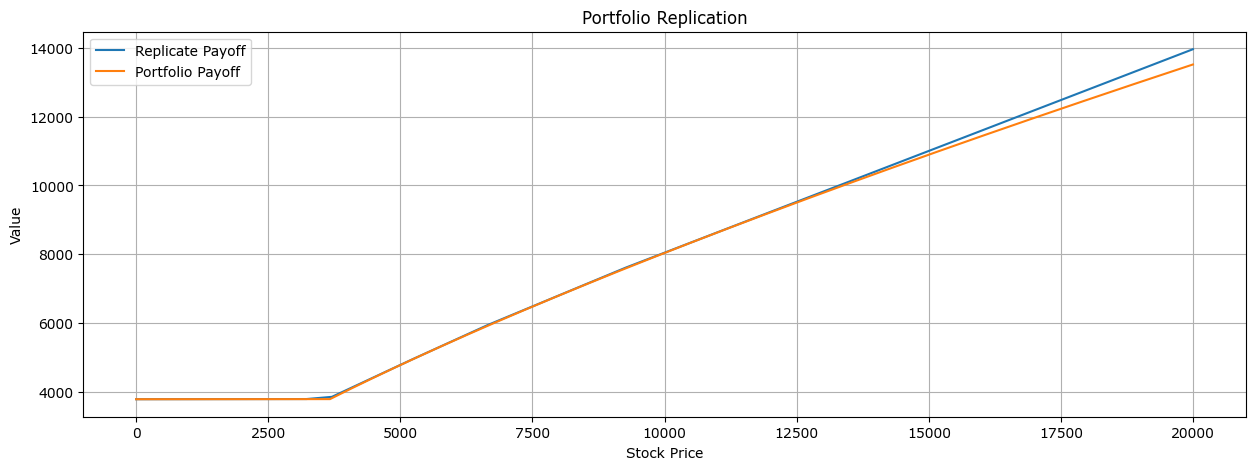

[5.87318570e-05 4.10711361e-05 3.13501311e-05 2.60280118e-05
 2.27324334e-05 1.15560649e-05 2.57792898e-06 1.09433682e-06
 1.59520904e-07 0.00000000e+00 0.00000000e+00 5.91617645e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.98814051e-06 7.00633433e-06 1.20187292e-05
 1.53113142e-05 1.78892264e-05 1.68376852e-02 6.14712987e-02
 8.30303783e-05 1.05271024e-04 1.22272467e-04 1.33685545e-04
 4.82366291e-02 0.00000000e+00 1.26295197e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.31881729e+03]


In [28]:
test_positions = np.array(position)
test_positions[-1] -= min(smallest_diff(position,0.01))
print(cost_cal(test_positions))
print(min(smallest_diff(test_positions,0.01)))
plot(0, 20000, test_positions)
print(test_positions)